
# Evaluation Tables & Figures

This notebook parses stored evaluation logs (e.g., `results/baseline_fast/logs/evaluate.log`),
builds summary tables, and plots per-class IoU for each experiment.



## Setup
- Ensure evaluation logs exist under `results/<exp>/logs/evaluate.log`.
- Install plotting deps if missing:
  ```bash
  pip install pandas matplotlib seaborn
  ```


In [13]:

from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

PROJECT_NAME = 'OccFormerWithWaymoData'
PROJECT_DIR = os.path.join(os.path.abspath('.').split(PROJECT_NAME)[0], PROJECT_NAME)
sys.path.append(PROJECT_DIR)

sns.set_theme(style="whitegrid")
RESULTS_ROOT = os.path.join(PROJECT_DIR, 'results')
LOG_NAME = "evaluate.log"



## Helpers
Parses the mmcv evaluation table at the end of each log. The parser is resilient to partial logs
and returns `None` if no table is found.


In [14]:

def parse_evaluate_log(log_path: Path):
    lines = log_path.read_text().splitlines()
    # Find the last table header
    start = None
    for i, line in enumerate(lines):
        if line.strip().startswith("Class") and "|" in line:
            start = i
    if start is None:
        return None

    records = []
    for line in lines[start:]:
        if "|" not in line or set(line.strip()) <= {"-", "+", "|"}:
            continue
        parts = [p.strip() for p in line.split("|") if p.strip()]
        if len(parts) != 2:
            continue
        cls, val = parts
        try:
            iou = float(val)
        except ValueError:
            continue
        records.append((cls, iou))

    if not records:
        return None

    df = pd.DataFrame(records, columns=["class", "iou"])
    miou = df.loc[df["class"] == "mIoU", "iou"]
    miou = float(miou.iloc[0]) if not miou.empty else None
    return df, miou



## Load available evaluations
Scans `results/*/logs/evaluate.log` and aggregates per-class IoU.


In [19]:

total_df = pd.DataFrame()
entries = []

for log_path in Path(RESULTS_ROOT).glob("*/logs/" + LOG_NAME):
    exp_name = log_path.parent.parent.name
    parsed = parse_evaluate_log(log_path)
    print(parsed)
    if parsed is None:
        print(f"[skip] No table found in {log_path}")
        continue
    df, miou = parsed
    df["experiment"] = exp_name
    total_df = pd.concat([total_df, df])
    entries.append((exp_name, miou, df))

display_entries = []
for exp_name, miou, df in entries:
    display_entries.append({"experiment": exp_name, "mIoU": miou})

summary = pd.DataFrame(display_entries).sort_values(by="mIoU", ascending=False)
summary


(                class    iou
0      general_object   0.00
1             vehicle  18.69
2          pedestrian   9.61
3                sign   1.79
4             cyclist   7.22
5       traffic_light   0.68
6                pole   4.34
7   construction_cone   4.05
8             bicycle   1.04
9          motorcycle   0.00
10           building   8.08
11         vegetation   7.78
12         tree_trunk   3.52
13               road  35.56
14           walkable  20.10
15               free  92.02
16               mIoU  13.41, 13.41)
(                class    iou
0      general_object   0.00
1             vehicle  18.36
2          pedestrian   9.62
3                sign   1.99
4             cyclist   3.34
5       traffic_light   1.72
6                pole   3.96
7   construction_cone   4.21
8             bicycle   0.01
9          motorcycle   0.00
10           building   8.33
11         vegetation   7.57
12         tree_trunk   3.13
13               road  26.19
14           walkable  18.98
15  

,experiment,mIoU
0,baseline_fast,13.41
1,strong_aug,12.43
2,sgd,11.97
3,lr_5e4,7.29



## Per-class IoU plot
Run this cell to plot per-class IoU for each parsed experiment.


In [22]:
total_df.to_csv(f"{PROJECT_DIR}/final_report/iou_result.csv")

/home/018219422/miniconda3/envs/occformer307/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


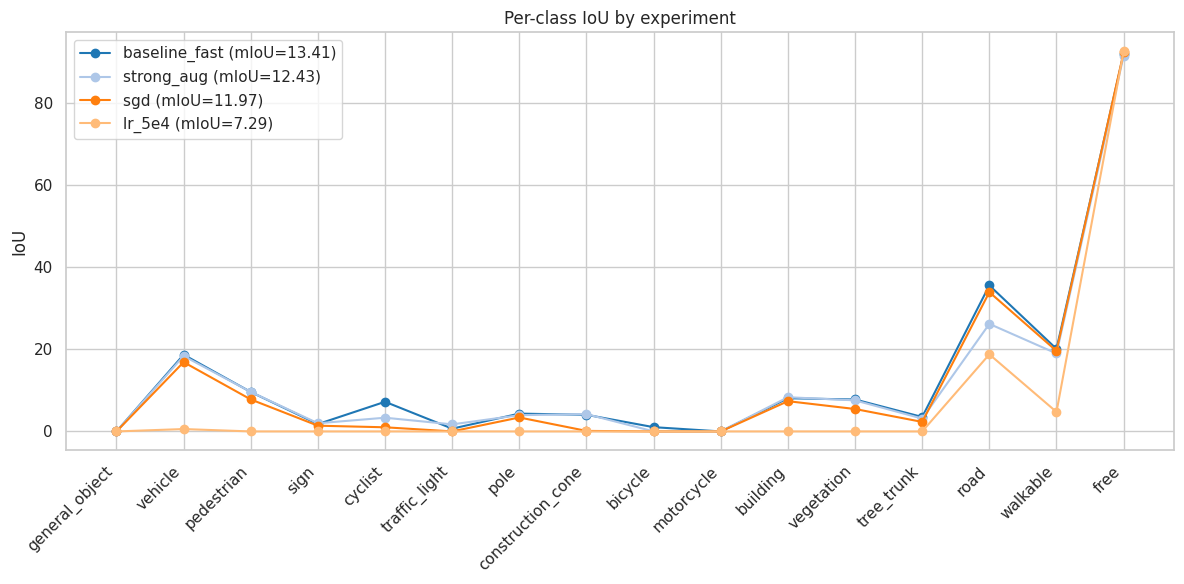

In [12]:

fig, ax = plt.subplots(figsize=(12, 6))
colors = sns.color_palette("tab20", len(entries))
for (exp_name, miou, df), color in zip(entries, colors):
    class_df = df[df["class"] != "mIoU"]
    ax.plot(class_df["class"], class_df["iou"], label=f"{exp_name} (mIoU={miou:.2f})", marker='o', color=color)

ax.set_ylabel("IoU")
ax.set_xticklabels(class_df["class"], rotation=45, ha='right')
ax.legend()
ax.set_title("Per-class IoU by experiment")
plt.tight_layout()
plt.show()
